# CNN - Feature Vector - Clustering

In this notebook we'll create a convolutional neural network in order to generate feature vectors out of our images. 
Training a CNN on our entire data set containing more than 11.000 product categories (label groups) would be computationally quite expensive. For that reason, the data set will be reduced to the 200 biggest label groups (these contain up to 50 pictures). This way our network will be trained to classify 200 different types of objects. In order to improve the training process, we will do a data augmentation on each cluster in order to increase the number of images available for each of the 200 categories. 

As our task is not about supervised learning but on clustering, creating a CNN to make good classification can only be a means to an end and certainly not an end in itself. Precisely, the purpose is to create feature vectors which then can by used to do what this project is about: Identifying product categories on our (reduced) image set. This idea to vectorize images with a newly created CNN stems from our need to find feature vectors which are generated by a model which is more specifically adapted to the images we work with. The approach of converting images into feature vectors was already followed in our base model. Yet, the results we got from this method still left plenty of room for improvement. Considering VGG16 was trained on images which are quite dissimilar from those we're now examining, this finding is not very surprising.

Once the CNN is trained, it can be used to undertake the transformation of the images into vectors. Contrary to the approach we followed with VGG16 where we cut off all the fully connected layers of our network and then made a 'prediction', we now pursue four different approaches: One by using the entire network, two more by cutting of the ultimate respectively the penultimate fully connected layer and finally, as we did with VGG16, by cutting off all the fully connected layers. The 'predictions' we obtain this way are precisely the feature vectors we desired. 

This way we'll get four different feature vectors out of every image. On all of these different vectors we'll apply three different clustering methods which then will be evaluated. We'll see that the results will rather be modest, but please be aware that the model we're presenting here can be seen rather as a first guess than as the result of a long and conceptual research. As CNN belong to the more sophisticated approaches in data science, we did not expect great results by simply testing some models anyway. Still, we decided to pursue this approach as we think that on the long run CNN is the type of model we expect the best results from. This notebook was rather meant to provide all the infrastructure needed to do the future work, which would mainly consist of redesigning the architecture of the CNN.

In [1]:
# Load libraries
import tensorflow as tf
import os
import pathlib
from pathlib import *
import matplotlib.pyplot as plt
import pickle
import numpy as np
import PIL
import PIL.Image
from tensorflow.keras import layers
from tensorflow import keras
import PIL
import PIL.Image
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
import scipy
import seaborn as sns

## Create and train a CNN

In [2]:
# Path where to find the images. The image files are grouped in folders by their true clusters (label group)
# These folders have the caption of the true cluster (label group)
p = Path("../input/shopee-product-matching/red200_inFolders_notAugmented/" )

In [3]:
# Image size and batch size for the data generator and model fitting
img_height = 224
img_width = 224
batch_size = 9

In [4]:
# Generate a TensorFlow data set 
def get_df(seed=0, validation_split=0.2, subset= "training",img_height = 224, img_width = 224, batch_size = 9):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        directory=p,
        validation_split=validation_split,
        subset=subset, 
        seed=seed,
        image_size=(img_height, img_width),
        batch_size=batch_size,
        shuffle=True
    );
    return ds

In [5]:
train_ds = get_df(subset="training")
class_names = train_ds.class_names

Found 3336 files belonging to 200 classes.
Using 2669 files for training.


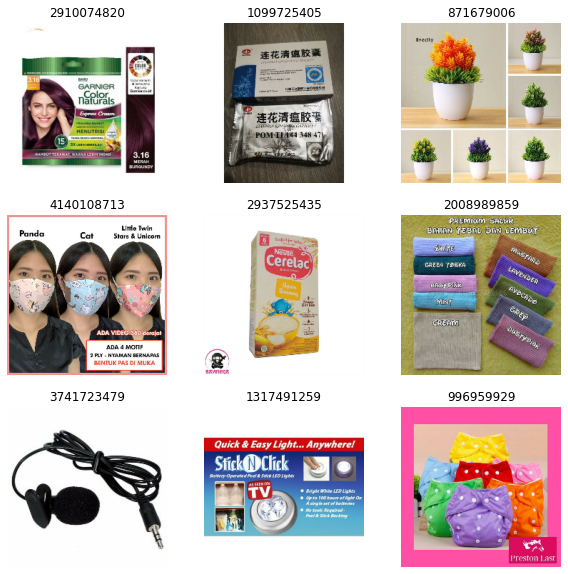

In [6]:
# Let's have a look at some random pictures. Above the image you'll see the true label group
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [7]:
# Resizing and rescaling layer. This layer will be included in our model we'll create below.
IMG_SIZE = 224
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

In [8]:
# Creating a layer in order to do data augmentation. This layer will be included in our model we'll create below.
data_augmentation = tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomFlip("vertical"),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1),
    ])

In [9]:
# Create the CNN
def create_model(num_classes = 200):
    model = tf.keras.Sequential([
        resize_and_rescale,
        data_augmentation,
        layers.Conv2D(128, 3, activation='relu',strides = (1,1)), 
        layers.MaxPooling2D(pool_size = (2,2), strides = 2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(pool_size = (2,2), strides = 2),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(pool_size = (2,2), strides = 2),
        layers.Flatten(name = "cnn"),
        layers.Dense(256, activation='relu', name = "full0"),
        layers.Dense(256, activation='relu', name = "full1"),
        layers.Dropout(0.2), 
        layers.Dense(num_classes, name = "full2"),
        layers.Softmax() 
    ])
    
    model.compile(
        optimizer='Adam', 
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )
    return model

In [10]:
model = create_model()

In [11]:
# Define a function that only trains one epoch in our CNN and therefore chooses a particular training
# and validation data set
def train_model(model, seed):
    train_ds = get_df(seed=seed, validation_split=0.2, subset= "training",img_height = 224, img_width = 224, batch_size = 9);
    val_ds = get_df(seed=seed, validation_split=0.2, subset= "validation",img_height = 224, img_width = 224, batch_size = 9);
    
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

    checkpoint_path = "models/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    model.fit(
        train_ds,
        validation_data=val_ds,
        callbacks=[cp_callback],
        epochs=1,
    )
    return model

In [12]:
# Function to train our model by repeatedly calling the function defined above. 
# Every epoch has a different training and validation data set

def train(model, epochs = 3):    
    interval = np.random.randint(0,1000,epochs)    
    for i, seed in enumerate(interval):
        print("Epoch: {}, seed: {}".format(i,seed))
        model = train_model(model, seed)
    return model

In [13]:
# Training the model
model = train(model,40)

Epoch: 0, seed: 467
Found 3336 files belonging to 200 classes.
Using 2669 files for training.
Found 3336 files belonging to 200 classes.
Using 667 files for validation.
297/297 [==============================] - 20s 48ms/step - loss: 5.2918 - accuracy: 0.0095 - val_loss: 5.2182 - val_accuracy: 0.0090

Epoch 00001: saving model to models/cp.ckpt
Epoch: 1, seed: 876
Found 3336 files belonging to 200 classes.
Using 2669 files for training.
Found 3336 files belonging to 200 classes.
Using 667 files for validation.
297/297 [==============================] - 13s 45ms/step - loss: 5.1033 - accuracy: 0.0221 - val_loss: 4.8825 - val_accuracy: 0.0315

Epoch 00001: saving model to models/cp.ckpt
Epoch: 2, seed: 583
Found 3336 files belonging to 200 classes.
Using 2669 files for training.
Found 3336 files belonging to 200 classes.
Using 667 files for validation.
297/297 [==============================] - 14s 46ms/step - loss: 4.7715 - accuracy: 0.0412 - val_loss: 4.6611 - val_accuracy: 0.0540

Epo

In [14]:
# Overview of the layers of our CNN
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)       

In [15]:
# Save the model
model.save("./models/cnn_Adam_crossentropy_64")

INFO:tensorflow:Assets written to: ./models/cnn_Adam_crossentropy_64/assets


In [16]:
# Friendly borrowed from Eike Rogall.
# Function to visualize the convolutional filters
def visualize_layer_kernels(img, conv_layer, title):

    weights1 = conv_layer.get_weights()
    kernels = weights1[0]
    kernels_num = kernels.shape[3]

    f, ax = plt.subplots(kernels_num, 3, figsize=(7, kernels_num * 2))

    for i in range(0, kernels_num):
        kernel = kernels[:, :, :3, i]
        ax[i][0].imshow((kernel * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][0].set_title("Kernel %d" % i, fontsize=9)

        ax[i][1].imshow((img * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][1].set_title("Before", fontsize=8)

        img_filt = scipy.ndimage.filters.convolve(img, kernel)
        ax[i][2].imshow((img_filt * 255).astype(np.uint8), vmin=0, vmax=255)
        ax[i][2].set_title("After", fontsize=8)

    plt.suptitle(title)
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

### See how the convolutional filters work

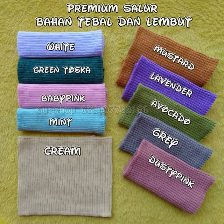

In [17]:
# Choose a random image to visualize how the convolutional filters works
i = np.random.randint(0,8,1)[0]
img = list(train_ds.take(1).as_numpy_iterator())[0][0][i]
tf.keras.preprocessing.image.array_to_img(img)

In [18]:
img = img / 255

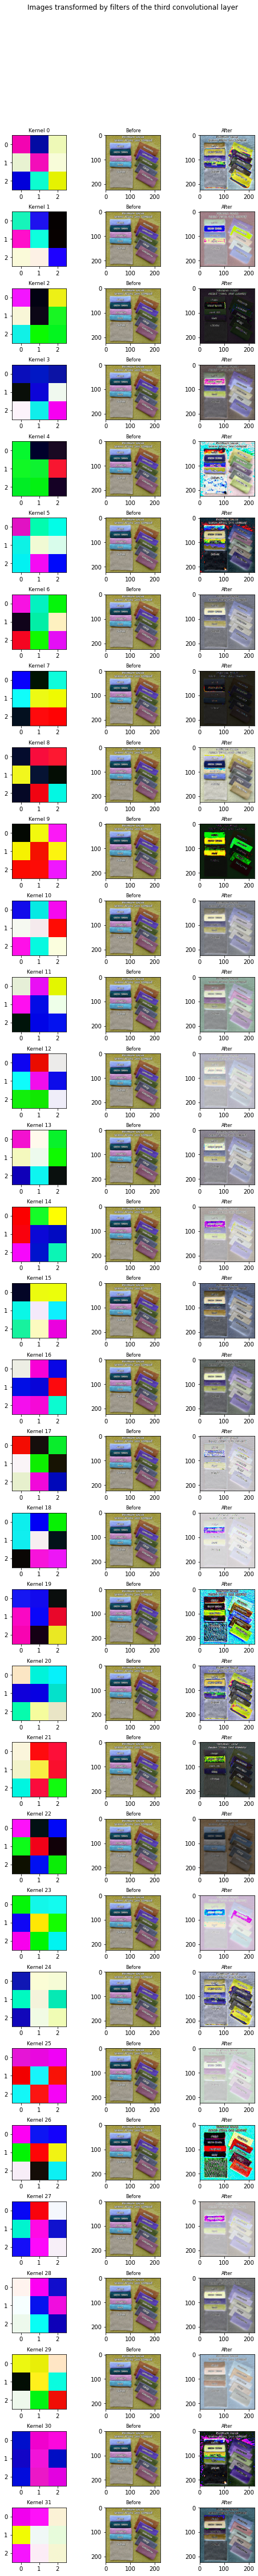

In [19]:
# Take last convolutional layer and see what its filters do
conv1 = model.layers[6]
visualize_layer_kernels(img, conv1, "Images transformed by filters of the third convolutional layer")

In [20]:
# Load model if it already exists
# model = tf.keras.models.load_model("./models/cnn_Adam_crossentropy_64")
# model.summary()

### Make a test prediction

In [21]:
# Create a data generator for the whole data set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=p,
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3336 files belonging to 200 classes.


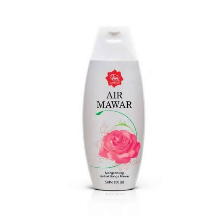

In [22]:
# Extract a batch
l = list(train_ds.take(1).as_numpy_iterator())[0]
# Get an image from the batch
lbl = l[1][0]
img = l[0][0]
# Show the image
tf.keras.preprocessing.image.array_to_img(np.array(img))

In [23]:
img_array = tf.expand_dims(img,0) 
pred = model.predict(img_array)
# Get the prediction scores and use softmax to turn them into probalities
score = tf.nn.softmax(pred[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence. It really belongs to {}"
    .format(class_names[np.argmax(score)], 100 * np.max(score), class_names[lbl])
)

This image most likely belongs to 562358068 with a 1.35 percent confidence. It really belongs to 562358068


### Create feature vectors with four submodels

First let's create the four submodels we talked about in the introduction.

In [24]:
sub_model_cnn = keras.Model(inputs=model.input,outputs=model.get_layer("cnn").output)
sub_model_full0 = keras.Model(inputs=model.input,outputs=model.get_layer("full0").output)
sub_model_full1 = keras.Model(inputs=model.input,outputs=model.get_layer("full1").output)
sub_model_full2 = keras.Model(inputs=model.input,outputs=model.get_layer("full2").output)

These submodels are now used to create the feature vectors our clustering will be based on.

In [25]:
df = pd.read_csv("../input/shopee-product-matching/red200.csv")
df = df[df["image_phash"] != "-1"]
df.path_old = df.path_old.apply(lambda x: "."+ x)

In [26]:
IMG_SIZE = 224
resize = tf.keras.Sequential([layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),])

def create_featureVectors(df,cnn_model):
    dic = dict()

    for pid in df.posting_id.values:
        po = df[df["posting_id"] == pid]["path_old"].values[0]
        img = PIL.Image.open(po)
        img = tf.keras.preprocessing.image.img_to_array(img)
        img = resize(img)
        img = tf.expand_dims(img,0)
        vec = cnn_model(img)
        vec = np.array(vec)
        vec = vec[0]
        dic[pid] = vec

    return dic

In [27]:
dic_fv_cnn = create_featureVectors(df,sub_model_cnn)
dic_fv_full0 = create_featureVectors(df,sub_model_full0)
dic_fv_full1 = create_featureVectors(df,sub_model_full1)
dic_fv_full2 = create_featureVectors(df,sub_model_full2)

### Principal component analysis

Now let's do a dimensionality reduction on our feature vectors via PCA. 

In [28]:
def pca_a_dict(dic, n=100):
    pca_encoder = PCA(n)
    l =   pca_encoder.fit_transform(list(dic.values()))
    keys = list(dic.keys())
    return dict(zip(keys,l))

In [29]:
dic_fv_cnn_pca   = pca_a_dict(dic_fv_cnn)
dic_fv_full0_pca = pca_a_dict(dic_fv_full0)
dic_fv_full1_pca = pca_a_dict(dic_fv_full1)
dic_fv_full2_pca = pca_a_dict(dic_fv_full2)

### Short EDA on the feature vectors

Evaluating the figures below, we see that the numbers of unique entries in the feature vectors we just created are quite low. Looking at some examples, we notice that a lot them are 0. Clustering on such feature vectors seems difficult and could be an explanation for the modest results we obtain below. The quality of a redesigned CNN must also be measured by the significance of the feature vectors it generates.

In [30]:
def plot_unique_vector_entries(dic_fv):
    sets = []
    for v in dic_fv.values():
        sets.append(len(set(v)))
    return sets

<AxesSubplot:ylabel='Count'>

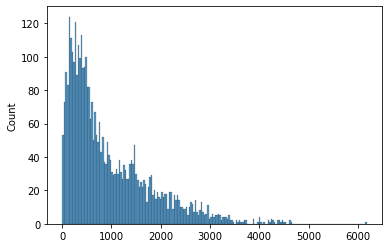

In [31]:
#CNN Layer
sets_cnn = plot_unique_vector_entries(dic_fv_cnn)
sns.histplot(x=sets_cnn,bins=200)

<AxesSubplot:ylabel='Count'>

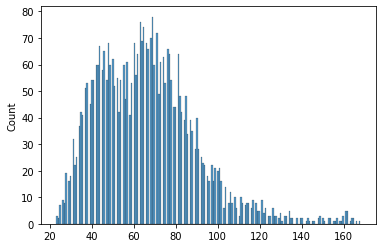

In [32]:
#Full0 Layer
sets_cnn_full0 = plot_unique_vector_entries(dic_fv_full0)
sns.histplot(x=sets_cnn_full0,bins=200)

<AxesSubplot:ylabel='Count'>

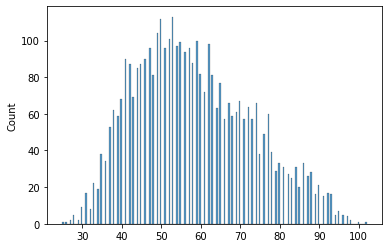

In [33]:
#Full1 Layer
sets_cnn_full1 = plot_unique_vector_entries(dic_fv_full1)
sns.histplot(x=sets_cnn_full1,bins=200)

<AxesSubplot:ylabel='Count'>

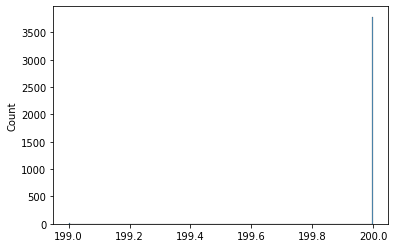

In [34]:
#Full2 Layer
sets_cnn_full2 = plot_unique_vector_entries(dic_fv_full2)
sns.histplot(x=sets_cnn_full2,bins=200)

## Clustering

Now we'll apply three different clustering methods both on the feature vectors which have been modified by PCA and those which have not. The clustering methods will be: Clustering via Euclidean distance, DBSCAN and k-Means.

### Clustering via Euclidean distance

In [35]:
# First define some functions we'll need for the evaluation.
def calc_distance(dic,pid):
    s1 = dic[pid]
    dist = list()
    for k in dic.keys():
        s2 = dic[k]
        d = np.sqrt(np.sum(np.square(s1 - s2)))
        dist.append(d)
    return dist

def check_one_pid(dic_fv, pid = "train_3645016213"):
    l = calc_distance(dic_fv, pid)
    l[:10]

    dist_df = pd.DataFrame({"posting_id":df.posting_id.values,
                            "label_group": df.label_group.values,
                            "distance": l,
                           })

    dist_df = dist_df.sort_values(by = "distance")
    return dist_df

def pred_cluster_of_pid_cnn(pid, dic_fv, threshold):
    fv1 = dic_fv[pid]    
    list_pid = list(dic_fv.keys())
    dist = calc_distance(dic_fv,pid)
    df_out = pd.DataFrame({"posting_id":list_pid, "distance":dist})
    df_out = df_out[df_out["distance"] <= threshold]    
    ls = df_out["posting_id"].tolist()
    return set(ls)

def real_cluster_of_pid(pid, df):
    df_red_list = df[df["posting_id"] == pid]["matches_true"].apply(lambda x: x.split()).values[0]
    return set(df_red_list)

def f_score(cl_real_i, cl_pred_i):
    s_pred = set(cl_pred_i)
    s_real = set(cl_real_i)
    s_intsec = s_pred.intersection(s_real)
    return 2*len(s_intsec) / (len(s_pred)+len(s_real))

def eval_f1(l_th, df, dic_fv):
    f1 = [[] for _ in range(len(l_th))]
    for i, th in enumerate(l_th):
        for pi in df.posting_id:
            f1[i].append(f_score(real_cluster_of_pid(pi, df),pred_cluster_of_pid_cnn(pi,dic_fv,th)))
        print("Threshold : {}      F1-Score: {}".format(th, np.sum(f1[i]) / len(f1[i])))
    return f1

In [36]:
# Submodel CNN without PCA
check_one_pid(dic_fv_cnn).head(5)

,posting_id,label_group,distance
0,train_3645016213,645628,0.000000
139,train_2034561720,159351600,6.064749
161,train_1142799664,159351600,6.296937
292,train_1484997819,417125601,6.298015
495,train_1319335009,656698835,6.299895


In [37]:
f1_Euklid_cnn = eval_f1([8.7],df,dic_fv_cnn)

Threshold : 8.7      F1-Score: 0.0321058426734602


In [38]:
# Submodel CNN with PCA
check_one_pid(dic_fv_cnn_pca).head(5)

,posting_id,label_group,distance
0,train_3645016213,645628,0.000000
139,train_2034561720,159351600,2.903465
38,train_2459849419,35254803,2.940918
493,train_18597875,656698835,3.185396
1993,train_2710211037,1815555102,3.267827


In [39]:
f1_Euklid_cnn_pca = eval_f1([4.2],df,dic_fv_cnn_pca)

Threshold : 4.2      F1-Score: 0.048308069406181806


In [40]:
# Submodel Full0 without PCA
check_one_pid(dic_fv_full0).head(5)

,posting_id,label_group,distance
0,train_3645016213,645628,0.000000
171,train_30488954,159351600,12.478967
7,train_318767180,645628,12.633242
3610,train_2410964577,4018561560,13.417950
406,train_1605540675,562358068,13.618880


In [41]:
f1_Euklid_full0 = eval_f1([11.8],df,dic_fv_full0)

Threshold : 11.8      F1-Score: 0.12477227819757053


In [42]:
# Submodel Full0 with PCA
check_one_pid(dic_fv_full0_pca).head(5)

,posting_id,label_group,distance
0,train_3645016213,645628,0.000000
171,train_30488954,159351600,11.301834
7,train_318767180,645628,11.664740
3609,train_4205044838,4018561560,12.226306
3610,train_2410964577,4018561560,12.234565


In [43]:
f1_Euklid_full0_pca = eval_f1([11.84],df,dic_fv_full0_pca)

Threshold : 11.84      F1-Score: 0.12366015701379889


In [44]:
# Submodel Full1 without PCA
check_one_pid(dic_fv_full1).head(5)

,posting_id,label_group,distance
0,train_3645016213,645628,0.000000
7,train_318767180,645628,10.427814
1757,train_429095784,1673669565,11.436749
493,train_18597875,656698835,11.625592
315,train_3024403050,418991059,11.761495


In [45]:
f1_Euklid_full1 = eval_f1([8.5],df,dic_fv_full1)

Threshold : 8.5      F1-Score: 0.1662918861745458


In [46]:
# Submodel Full1 with PCA
check_one_pid(dic_fv_full1_pca).head(5)

,posting_id,label_group,distance
0,train_3645016213,645628,0.000000
7,train_318767180,645628,9.015089
493,train_18597875,656698835,10.283229
1757,train_429095784,1673669565,10.484683
171,train_30488954,159351600,10.574811


In [47]:
f1_Euklid_full1_pca = eval_f1([7.3],df,dic_fv_full1_pca)

Threshold : 7.3      F1-Score: 0.17156241877468809


In [48]:
# Submodel Full2 without PCA
check_one_pid(dic_fv_full2).head(5)

,posting_id,label_group,distance
0,train_3645016213,645628,0.000000
143,train_799363063,159351600,74.079666
167,train_2266041454,159351600,74.150963
2428,train_2689213653,2609303586,77.487930
171,train_30488954,159351600,79.288811


In [49]:
f1_Euklid_full2 = eval_f1([36.0],df,dic_fv_full2)

Threshold : 36.0      F1-Score: 0.12939201455780344


In [50]:
# Submodel Full2 with PCA
check_one_pid(dic_fv_full2_pca).head(5)

,posting_id,label_group,distance
0,train_3645016213,645628,0.000000
143,train_799363063,159351600,73.557146
167,train_2266041454,159351600,73.569441
2428,train_2689213653,2609303586,76.884773
171,train_30488954,159351600,79.036293


In [51]:
f1_Euklid_full2_pca = eval_f1([36.1],df,dic_fv_full2_pca)

Threshold : 36.1      F1-Score: 0.1303052815604624


### DBSCAN

In [52]:
# Define an alternative way to calculate the F1-Score. This method will be used both for DBSCAN and for k-Means.
def f1_score(y_true, y_pred):
    y_true = y_true.split()
    intersection = np.intersect1d(y_true,y_pred)
    intersection = len(intersection)
    len_y_pred = len(y_pred)
    len_y_true = len(y_true)
    f1 = 2 * intersection / (len_y_pred + len_y_true)
    return f1

In [53]:
def dbscan_f1( dic, df, eps = 0.5, min_samples = 3):
    db_scan_model = DBSCAN(
                        eps=eps,
                        min_samples=min_samples,
                        metric='euclidean',
                        metric_params=None,
                        algorithm='auto',
                        leaf_size=30,
                        p=None,
                        n_jobs=None,
                    )

    db_pred = db_scan_model.fit_predict(list(dic.values()))
    print("There are {} clusters.".format(len(set(db_pred))))
    
    df["db_scan"] = db_pred

    tmp = df.groupby(['db_scan'])['posting_id'].unique().to_dict()

    if -1 in tmp.keys():
        del tmp[-1]

    df["db_scan"] = [x if df[df["posting_id"] == x]["db_scan"].values[0] == -1 else tmp[df[df["posting_id"] == x]["db_scan"].values[0]] for x in df.posting_id ]

    f1_db_scan = []
    for y_true, y_pred in zip(df.matches_true.values, df.db_scan.values):
        f1_db_scan.append(f1_score(y_true, y_pred))

    return np.sum(f1_db_scan)/len(f1_db_scan)
    

In [54]:
# Submodel CNN without PCA
check_one_pid(dic_fv_cnn).head(5)

,posting_id,label_group,distance
0,train_3645016213,645628,0.000000
139,train_2034561720,159351600,6.064749
161,train_1142799664,159351600,6.296937
292,train_1484997819,417125601,6.298015
495,train_1319335009,656698835,6.299895


In [55]:
f1_dbscan_cnn = dbscan_f1(dic_fv_cnn, df,eps=8.8, min_samples=3)
f1_dbscan_cnn

There are 6 clusters.


0.02200938494404703

In [56]:
# Submodel CNN with PCA
check_one_pid(dic_fv_cnn_pca).head(5)

,posting_id,label_group,distance
0,train_3645016213,645628,0.000000
139,train_2034561720,159351600,2.903465
38,train_2459849419,35254803,2.940918
493,train_18597875,656698835,3.185396
1993,train_2710211037,1815555102,3.267827


In [57]:
f1_dbscan_cnn_pca = dbscan_f1(dic_fv_cnn_pca, df,eps=4.2, min_samples=3)
f1_dbscan_cnn_pca

There are 25 clusters.


0.026530483983176135

In [58]:
# Submodel Full0 without PCA
check_one_pid(dic_fv_full0).head(5)

,posting_id,label_group,distance
0,train_3645016213,645628,0.000000
171,train_30488954,159351600,12.478967
7,train_318767180,645628,12.633242
3610,train_2410964577,4018561560,13.417950
406,train_1605540675,562358068,13.618880


In [59]:
f1_dbscan_full0 = dbscan_f1(dic_fv_full0, df,eps=11.7, min_samples=3)
f1_dbscan_full0

There are 57 clusters.


0.06128419023705054

In [60]:
# Submodel Full0 with PCA
check_one_pid(dic_fv_full0_pca).head(5)

,posting_id,label_group,distance
0,train_3645016213,645628,0.000000
171,train_30488954,159351600,11.301834
7,train_318767180,645628,11.664740
3609,train_4205044838,4018561560,12.226306
3610,train_2410964577,4018561560,12.234565


In [61]:
f1_dbscan_full0_pca = dbscan_f1(dic_fv_full0_pca, df,eps=11.8, min_samples=3)
f1_dbscan_full0_pca

There are 50 clusters.


0.06668381141878861

In [62]:
# Submodel Full1 without PCA
check_one_pid(dic_fv_full1).head(5)

,posting_id,label_group,distance
0,train_3645016213,645628,0.000000
7,train_318767180,645628,10.427814
1757,train_429095784,1673669565,11.436749
493,train_18597875,656698835,11.625592
315,train_3024403050,418991059,11.761495


In [63]:
f1_dbscan_full1 = dbscan_f1(dic_fv_full1, df,eps=10.6, min_samples=3)
f1_dbscan_full1

There are 74 clusters.


0.08469989451179735

In [64]:
# Submodel Full1 with PCA
check_one_pid(dic_fv_full1_pca).head(5)

,posting_id,label_group,distance
0,train_3645016213,645628,0.000000
7,train_318767180,645628,9.015089
493,train_18597875,656698835,10.283229
1757,train_429095784,1673669565,10.484683
171,train_30488954,159351600,10.574811


In [65]:
f1_dbscan_full1_pca = dbscan_f1(dic_fv_full1_pca, df,eps=7.3, min_samples=3)
f1_dbscan_full1_pca

There are 87 clusters.


0.09657124811177674

In [66]:
# Submodel Full2 without PCA
check_one_pid(dic_fv_full2).head(5)

,posting_id,label_group,distance
0,train_3645016213,645628,0.000000
143,train_799363063,159351600,74.079666
167,train_2266041454,159351600,74.150963
2428,train_2689213653,2609303586,77.487930
171,train_30488954,159351600,79.288811


In [67]:
f1_dbscan_full2 = dbscan_f1(dic_fv_full2, df,eps=36.0, min_samples=3)
f1_dbscan_full2

There are 61 clusters.


0.08085460329988611

In [68]:
# Submodel Full2 with PCA
check_one_pid(dic_fv_full2_pca).head(5)

,posting_id,label_group,distance
0,train_3645016213,645628,0.000000
143,train_799363063,159351600,73.557146
167,train_2266041454,159351600,73.569441
2428,train_2689213653,2609303586,76.884773
171,train_30488954,159351600,79.036293


In [69]:
f1_dbscan_full2_pca = dbscan_f1(dic_fv_full2_pca, df,eps=36.0, min_samples=3)
f1_dbscan_full2_pca

There are 64 clusters.


0.08193595469714346

### k - Means

In [70]:
def kmeans_f1(dic, df, n=200):
              
    kmeans_model = KMeans(n)
    pred_kmeans = kmeans_model.fit_predict(list(dic.values()))
    df["kmeans"] = pred_kmeans
    tmp = df.groupby(['kmeans'])['posting_id'].unique().to_dict()
    if -1 in tmp.keys():
        del tmp[-1]
    len(tmp)
    df["kmeans"] = [x if df[df["posting_id"] == x]["kmeans"].values[0] == -1 else tmp[df[df["posting_id"] == x]["kmeans"].values[0]] for x in df.posting_id ]
    f1_kmeans = []    
    for y_true, y_pred in zip(df.matches_true.values, df.kmeans.values):
        f1_kmeans.append(f1_score(y_true, y_pred))
        
    return np.sum(f1_kmeans)/len(f1_kmeans) 

In [71]:
# Submodel CNN without PCA
f1_kmeans_cnn = kmeans_f1(dic_fv_cnn, df)
f1_kmeans_cnn

0.0495438100768142

In [72]:
# Submodel CNN with PCA
f1_kmeans_cnn_pca = kmeans_f1(dic_fv_cnn_pca, df)
f1_kmeans_cnn_pca

0.08544505732829895

In [73]:
# Submodel Full0 without PCA
f1_kmeans_full0 = kmeans_f1(dic_fv_full0, df)
f1_kmeans_full0

0.21992587129070656

In [74]:
# Submodel Full0 with PCA
f1_kmeans_full0_pca = kmeans_f1(dic_fv_full0_pca, df)
f1_kmeans_full0_pca

0.21234856520506742

In [75]:
# Submodel Full1 without PCA
f1_kmeans_full1 = kmeans_f1(dic_fv_full1, df)
f1_kmeans_full1

0.2977479776554876

In [76]:
# Submodel Full1 with PCA
f1_kmeans_full1_pca = kmeans_f1(dic_fv_full1_pca, df)
f1_kmeans_full1_pca

0.2950873509813867

In [77]:
# Submodel Full2 without PCA
f1_kmeans_full2 = kmeans_f1(dic_fv_full2, df)
f1_kmeans_full2

0.18437426670380253

In [78]:
# Submodel Full2 with PCA
f1_kmeans_full2_pca = kmeans_f1(dic_fv_full2_pca, df)
f1_kmeans_full2_pca

0.1852945676758754

### Display results in one DataFrame

In [79]:
df_results = pd.DataFrame({"KMeans":[f1_kmeans_cnn, f1_kmeans_full0, f1_kmeans_full1, f1_kmeans_full2], 
                           "KMeans_pca":[f1_kmeans_cnn_pca, f1_kmeans_full0_pca, f1_kmeans_full1_pca, f1_kmeans_full2_pca],
                           "Euclid":[np.sum(f1_Euklid_cnn[0]) / len(f1_Euklid_cnn[0]),
                                     np.sum(f1_Euklid_full0[0]) / len(f1_Euklid_full0[0]), 
                                     np.sum(f1_Euklid_full1[0]) / len(f1_Euklid_full1[0]),
                                     np.sum(f1_Euklid_full2[0]) / len(f1_Euklid_full2[0])],
                           "Euclid_pca":[np.sum(f1_Euklid_cnn_pca[0]) / len(f1_Euklid_cnn_pca[0]),
                                         np.sum(f1_Euklid_full0_pca[0]) / len(f1_Euklid_full0_pca[0]), 
                                         np.sum(f1_Euklid_full1_pca[0]) / len(f1_Euklid_full1_pca[0]), 
                                         np.sum(f1_Euklid_full2_pca[0]) / len(f1_Euklid_full2_pca[0])],
                           "DBSCAN":[f1_dbscan_cnn, f1_dbscan_full0, f1_dbscan_full1, f1_dbscan_full2],
                           "DBSCAN_pca":[f1_dbscan_cnn_pca, f1_dbscan_full0_pca, f1_dbscan_full1_pca, f1_dbscan_full2_pca]},
                           index=["cnn", "full0",  "full1", "full2"])
df_results = round(df_results,3)

In [80]:
df_results

,KMeans,KMeans_pca,Euclid,Euclid_pca,DBSCAN,DBSCAN_pca
cnn,0.050,0.085,0.032,0.048,0.022,0.027
full0,0.220,0.212,0.125,0.124,0.061,0.067
full1,0.298,0.295,0.166,0.172,0.085,0.097
full2,0.184,0.185,0.129,0.130,0.081,0.082


## Future work

+ Most important: Pursue a more conceptual approach to redesign the CNN
+ Test further clustering algorithms
